# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial to play with it yourself.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Install detectron2

In [0]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-bvuycg1m
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-bvuycg1m
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-64cn5ajx
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-64cn5ajx
     |████████████████████████████████| 266kB 4.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=47493 sha256=f143dbbc77d7ed3766f377ea01ba4aa2f6ca4b7e60f68eb889ada155504baf47
  Stored in directory: /tmp/pip-ephem-wheel-cache-mdjtutzp/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel f

'1.3.1'

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 1345, done.
remote: Total 1345 (delta 0), reused 0 (delta 0), pack-reused 1345
Receiving objects: 100% (1345/1345), 1.60 MiB | 1.49 MiB/s, done.
Resolving deltas: 100% (809/809), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.1MB 2.7MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use our annotated dataset that only contains one class:
artwork to detect.

We'll train a artwork segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.


## Prepare the dataset

In [0]:
!git clone https://github.com/gestaltrevision/tracking-vermeersch.git tracking_art

Cloning into 'tracking_art'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 74 (delta 6), reused 69 (delta 5), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [0]:
from thesis_utilities import *



In [0]:
picture_path="tracking_art/Data/picture"
picture_metadata=register_dataset("picture",picture_path)

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



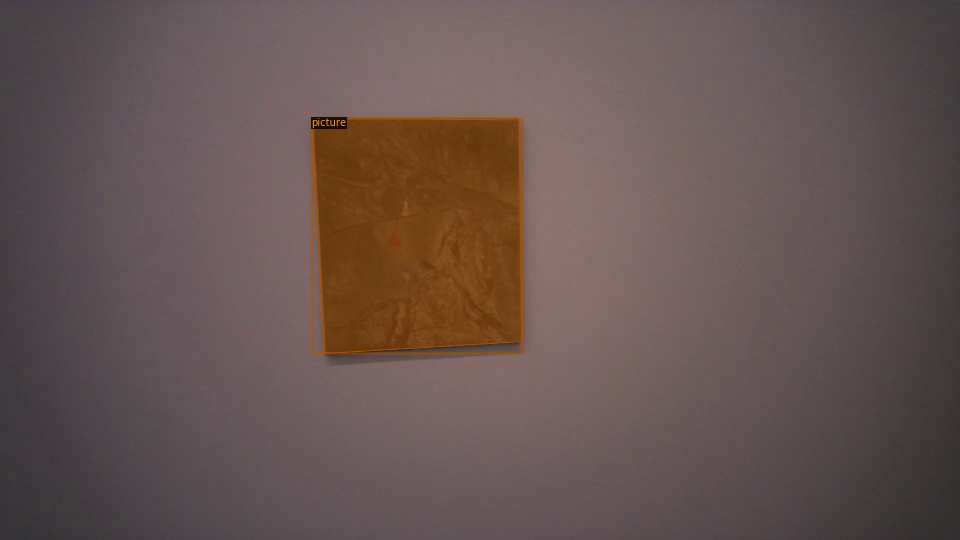

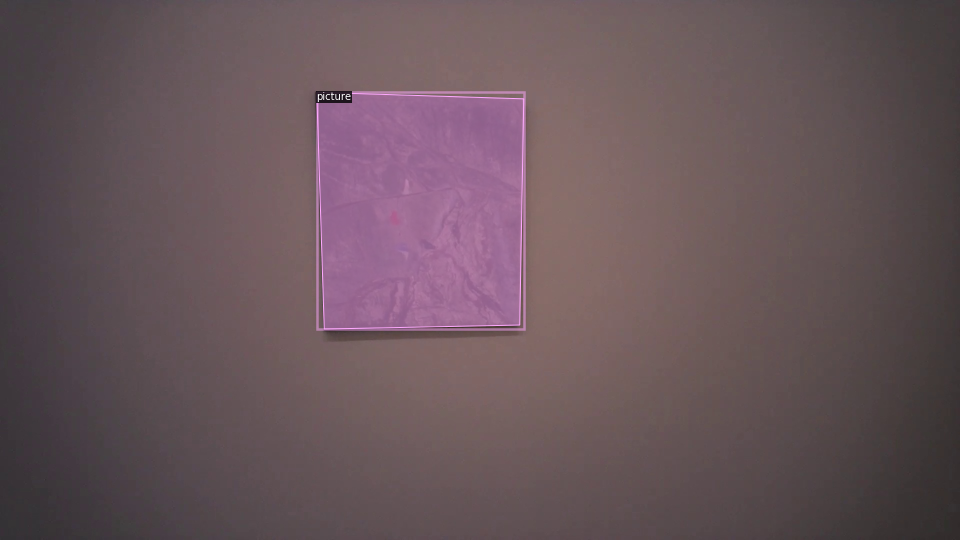

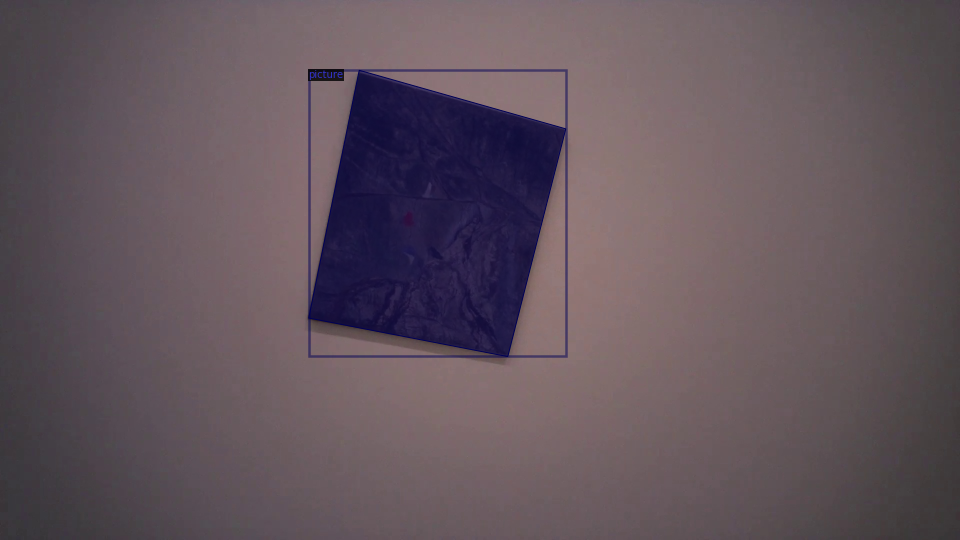

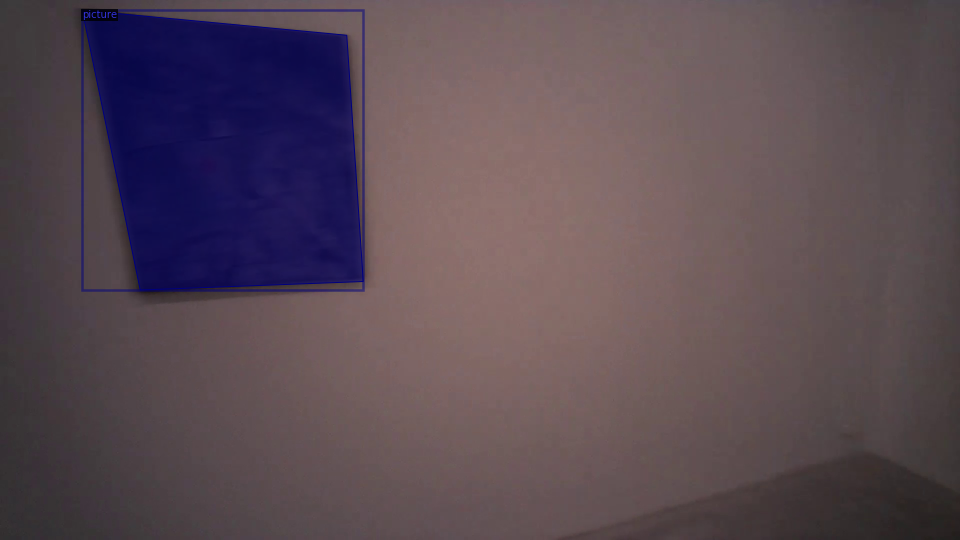

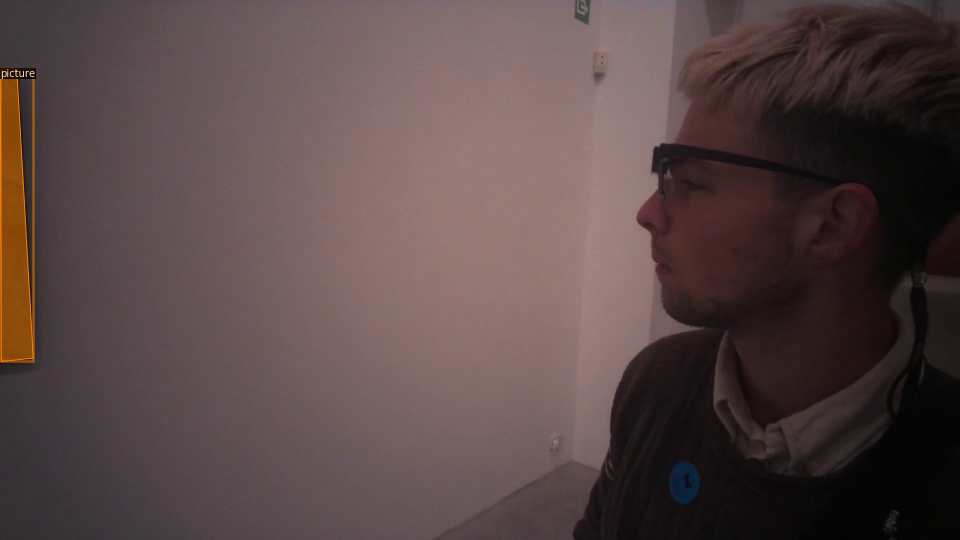

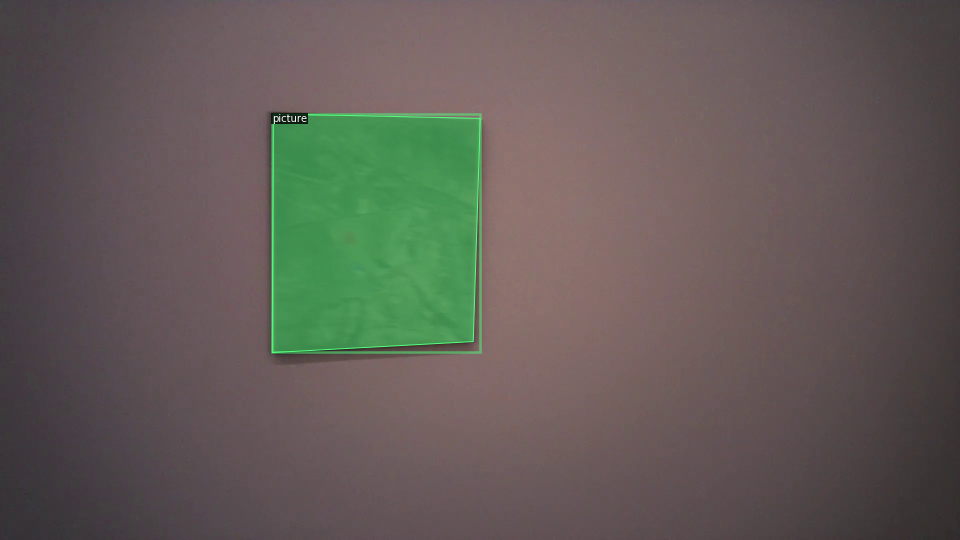

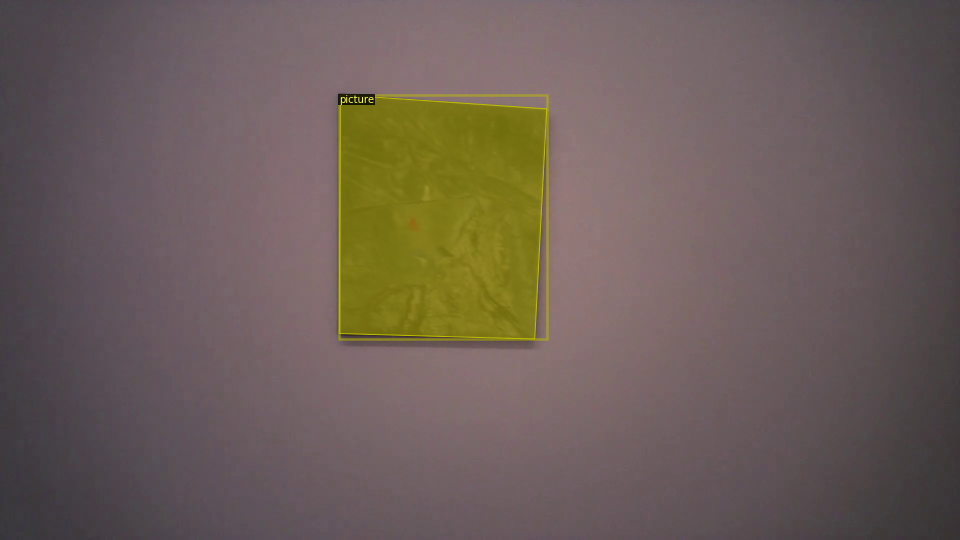

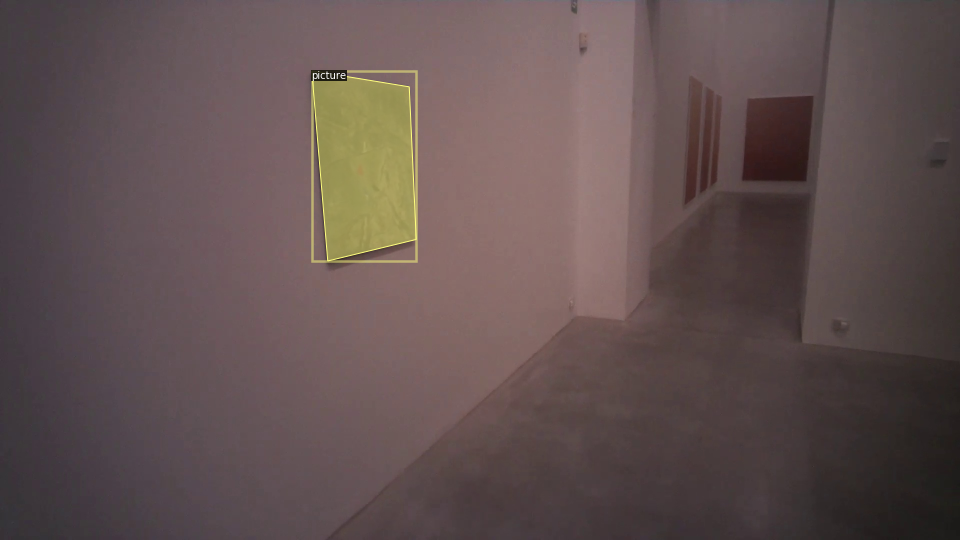

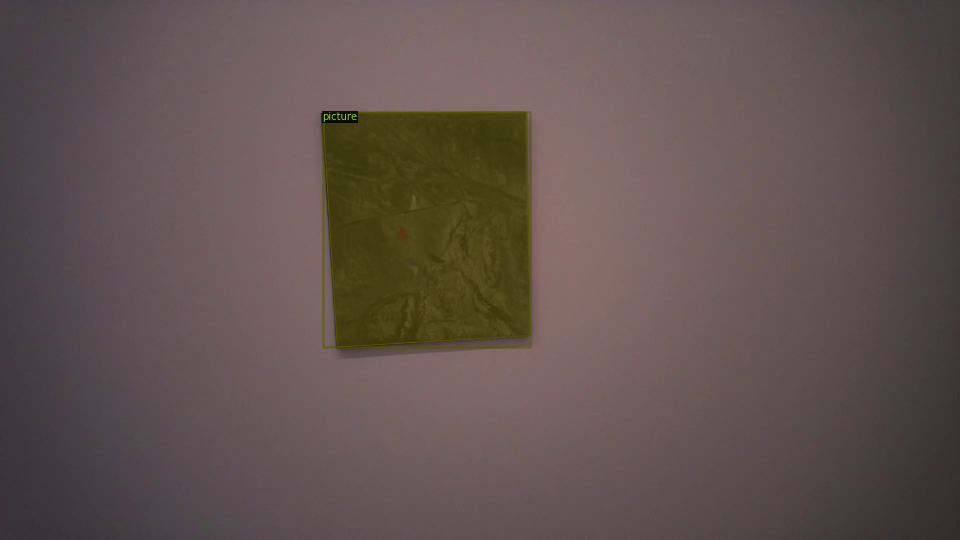

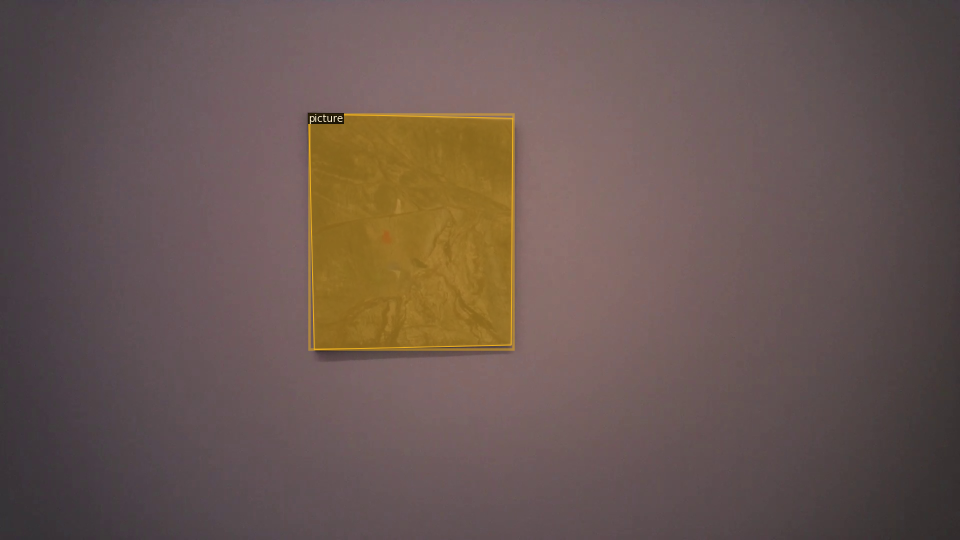

In [0]:
dataset_dicts = get_class_dicts("/content/tracking_art/Data/picture/train")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=picture_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  #Test differents pretrained archs
cfg.DATASETS.TRAIN = ("picture_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (picture)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("picture_val", )
predictor = DefaultPredictor(cfg)

NameError: ignored

In [0]:
# Download the model
from google.colab import files
files.download(cfg.MODEL.WEIGHTS)

Then, we randomly select several samples to visualize the prediction results.

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_picture_dicts("picture/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=picture_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("picture_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "picture_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test


# Run panoptic segmentation on a video

In [0]:
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv


In [0]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using our trained model
!cd detectron2_repo && python demo/demo_mod.py --config-file  configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml --video-input ../pruebas_video.mp4 --confidence-threshold 0.5 --output ../video-output.avi \
  --opts MODEL.WEIGHTS /content/output/model_final.pth

In [0]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

#Hard Coded video segmentation

In [0]:
from detectron2.utils.visualizer import ColorMode
from time import time
import os


video_file="/content/pruebas_video.mp4"
video=cv2.VideoCapture(video_file)

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)

video_folder="/content/video-output.avi"

out = cv2.VideoWriter(video_folder,cv2.VideoWriter_fourcc(*'DIVX'), frames_per_second, (width,height))

count=0

begin=time()


imgs_folder="/content/imgs"

assert os.path.isdir(imgs_folder) , "create the folder"
assert video.isOpened(), "Error opening the video"


while (video.isOpened()):
    ret,frame=video.read()
    if ret==True:
      count+=1
      frame_name="frame{0}.jpg".format(count)
      img_file=os.path.join(imgs_folder,frame_name)
      outputs=predictor(frame)
      v = Visualizer(frame[:, :, ::-1],
                  metadata=picture_metadata, 
                  scale=0.8, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      img_annotated=v.get_image()[:,:,::-1]
      cv2.imwrite(img_file,img_annotated)
      print("Frame {0} saved".format(count))
    
      if cv2.waitKey(0) == 27:
                    break  # esc to quit
    else:
      break


video.release()
# out.release()
end=time()

total_elapsed=end-begin

print("Time to process the video = {0}".format(total_elapsed))


# Hard coded video

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  #Test differents pretrained archs
cfg.DATASETS.TRAIN = ("picture_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (picture)

#We build the detector using our trained model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("picture_val", )
predictor = DefaultPredictor(cfg)

WARNING [11/20 09:45:22 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [0]:

def predictions_from_video(video_file, frames_folder):

    # We create the dir for the destination folder if it is not yet created
    if(not(os.path.isdir(frames_folder))):
        os.makedirs(frames_folder)

    video = cv2.VideoCapture(video_file)
    assert video.isOpened(), "Error opening the video"

    begin = time()
    count = 0
    while (video.isOpened()):

        ret, frame = video.read()
        if ret == True:
            count += 1
            frame_name = "frame{0}.jpg".format(count)
            img_file = os.path.join(frames_folder, frame_name)
            outputs = predictor(frame)
            v = Visualizer(frame[:, :, ::-1],
                           metadata=picture_metadata,
                           scale=0.8,
                           instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
                           )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            img_annotated = v.get_image()[:, :, ::-1]
            cv2.imwrite(img_file, img_annotated)
            print("Frame {0} saved".format(count))

            if cv2.waitKey(0) == 27:
                break  # esc to quit
        else:
            break

    video.release()
    end = time()
    total_elapsed = end-begin

    print("Time to process the video = {0}".format(total_elapsed))

In [0]:
video_path="/content/tracking_art/Data/pruebas_video.mp4"
frames_folder="/content/framesresult"
predictions_from_video(video_path,frames_folder)

In [0]:

def frames_to_video(frames_folder,video_folder,root_name,frames_ext):
    
    img_array = []
    # glob_pattern= frames_folder +"/*"+ frames_ext
    # frames_list=glob.glob(glob_pattern)
    frames_list = [file for file in os.listdir(frames_folder) if root_name in file]


    #Explain lambda function
    frames_list_sorted=sorted(frames_list,key= lambda x : int(x.split(root_name)[1].split(frames_ext)[0])) 
    print(frames_list_sorted)

    for filename in frames_list_sorted:
        img_path=os.path.join(frames_folder,filename)
        img = cv2.imread(img_path)
        img_array.append(img)
    
    height, width, _ = img.shape
    size = (width,height)
    
    out = cv2.VideoWriter(video_folder,cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [0]:
video_folder="/content/video-output.avi"

base_name="frame"
frames_ext=".jpg"

frames_to_video(frames_folder,video_folder,base_name,frames_ext)

['frame1.jpg', 'frame2.jpg', 'frame3.jpg', 'frame4.jpg', 'frame5.jpg', 'frame6.jpg', 'frame7.jpg', 'frame8.jpg', 'frame9.jpg', 'frame10.jpg', 'frame11.jpg', 'frame12.jpg', 'frame13.jpg', 'frame14.jpg', 'frame15.jpg', 'frame16.jpg', 'frame17.jpg', 'frame18.jpg', 'frame19.jpg', 'frame20.jpg', 'frame21.jpg', 'frame22.jpg', 'frame23.jpg', 'frame24.jpg', 'frame25.jpg', 'frame26.jpg', 'frame27.jpg', 'frame28.jpg', 'frame29.jpg', 'frame30.jpg', 'frame31.jpg', 'frame32.jpg', 'frame33.jpg', 'frame34.jpg', 'frame35.jpg', 'frame36.jpg', 'frame37.jpg', 'frame38.jpg', 'frame39.jpg', 'frame40.jpg', 'frame41.jpg', 'frame42.jpg', 'frame43.jpg', 'frame44.jpg', 'frame45.jpg', 'frame46.jpg', 'frame47.jpg', 'frame48.jpg', 'frame49.jpg', 'frame50.jpg', 'frame51.jpg', 'frame52.jpg', 'frame53.jpg', 'frame54.jpg', 'frame55.jpg', 'frame56.jpg', 'frame57.jpg', 'frame58.jpg', 'frame59.jpg', 'frame60.jpg', 'frame61.jpg', 'frame62.jpg', 'frame63.jpg', 'frame64.jpg', 'frame65.jpg', 'frame66.jpg', 'frame67.jpg', 'fr

#Mounting Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
